<b><h1><center>Convolution Neural Network (using Dataset = MNIST --> Hand Written Digits)

This tutorial is about implementing a Convolutional Neural Network using TensorFlow.

In Convolutional Networks, small filters are moved across the input images. These filters are re-used to recognize pattern in the entire input image. This property of recognizing patterns in the images using filters make Convolutional Networks more powerful, faster and accurate as compared to the Fully Connected Networks with the same number of variables.

The pre-requisites for this tutorial include basic know ledge of Linear Algebra, Convolutional Neural Networks and Layers, Python programming language and Jupyter Notebook editor.

The tutorial consists of 2 Convolutional Layers. 16 filters are apllied on the 1st layer and 36 filters are applied on the 2nd layer. Filters process the images using filter-weights. The output of the 2nd Convoluational Layer is then flattened and fed as an input to a Fully Connected Layer of 128 Neurons. In the end, the output generated from this Fully Connected Layer is then fed to another Fully Connected Layer of 10 Neurons (each of the 10 Neurons representing a separate class).

Cross-Entropy is used to measure the error between the predicted and real class of each image. The error is then propagated back to the Neural Network via the Optimizer. This updates the filter-weights in order to improve the classification error. A number of iterations are performed to minimize the classification error.

To make the computation more efficient, the computation in TensorFlow is done on a batch of images instead of a single image.

<b><h2>Importing Libraries

Following are the libraries that will be used for the entire tutorial.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import math
from datetime import timedelta

<b><h2>Importing Data

The data set used for the tutorial is MNIST dataset that consists of hand-written digits from 0 to 9. That means the dataset has 10 different classes. The dataset can be downloaded and loaded automatically or can also be loaded manually by downloading the dataset from an online source.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The dataset consists of 70,000 images with associated labels (class of each image). The entire dataset is already divided into 3 division sets; Training, Testing and Valadating datasets. In this tutorial, only the Training and Testing dataset divisions will be used.

In [3]:
print("Size of:")
print("Training Sets:\t\t{}".format(len(data.train.labels)))
print("Test Sets:\t\t{}".format(len(data.test.labels)))
print("Validation Sets:\t{}".format(len(data.validation.labels)))

Size of:
Training Sets:		55000
Test Sets:		10000
Validation Sets:	5000


Each class-label is a vector of 10 elements. This means that, the labels that represent the class of each image are One-Hot encoded. One-hot encoding refers to the fact that the 10 elements of the vector are all zero except for 1 whose index is the class-number of the associated image.

The class number of each image of the test set will also be needed in this tutorial which is calculated as follows.

In [4]:
class_number = np.argmax(data.test.labels, axis=1)

<b><h2>Data Dimensions

The data dimensions are defined once that can be used further using their variable names.

In [5]:
# Size of each image (MNIST dataset images are of 28×28 pixels)
size_of_image = 28

#Size of each image after it is flattened to feed the Fully-Connected Layer
size_of_image_flattened = size_of_image * size_of_image

#Shape of each image
shape_of_image = (size_of_image, size_of_image)

#Number of Classes (MNIST dataset has 10 classes)
nc = 10

#Number of Color Channels (MNIST dataset of hand-written digits has only 1 color channels: gray-scale)
nch = 1

<b><h2>Helper Function to Plot Images

This is a function that will be called to plot 9 images in a grid of 3×3. The real and predicted class of each image will also be shown below that particular image.

In [6]:
def plot_images(images, real_class, predicted_class=None):
    assert len(images) == len(real_class) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(shape_of_image), cmap='binary')

        if predicted_class is None:
            xlabel = "True: {0}".format(real_class[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(real_class[i], predicted_class[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

<b><h2>Checking and Plotting Real Classes of a few Images

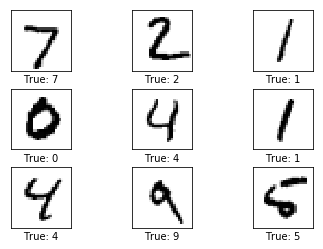

In [7]:
images = data.test.images[0:9]
real_class = class_number[0:9]
plot_images(images=images, real_class=real_class)

<b><h2>TensorFlow Graph

The purpose of using TensorFlow is to have a computational graph for efficient execution. This is far better than the calculations performed directly in Python.

For better model performance, TensorFlow automatically calculates the gradients that are required to optimize the graph variables.

A TensorFlow graph consists of:
-  Placeholder Variables to input the data later on.
-  Variables that are to be optimized.
-  Mathematical Formulas and Calculations.
-  A Cost Measure for Optimization.
-  An Optimization Method to update Variables.

<b><h2>Helper Functions to Create Variables

Below are two helper functions that create TensorFlow variables of a particular given shape and are initialized randomly.

In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

<b><h2>Helper Function to Create a Convolutional Layer

Below is the function that can be called to create a Convolutional Layer in the Convolutional Graph of the TensorFlow.

The input is assumed to be a 4-dim tensor with the following dimensions:
-  Number of Images.
-  Y-Axis of each image.
-  X-Axis of each image.
-  Number of Channels of the Image.

The Number of Channels of the Image can either be Color-Channels or Filter-Channels. For the 1st layer, the channels will be color-channels but if the output of a previous convolutional layer is being used as an input in the current convolutional layer, then the channels ill be filter channels.

The output of the image is then also a 4-dim tensor with the following dimensions.
-  Number of Images. (Same as input)
-  Y-Axis of each image. (If 2×2 Pooling is used, then the height and width of images are divided by 2)
-  X-Axis of each image. (Same as input)
-  Number of Channels of the Image. (As produced by the Convolutional Filters)

In [9]:
def new_conv_layer(input,                # Data (for first layer) else the previous layer
                   number_of_channels,   # Number of color-channels for 1st layer else channels of previous layer
                   size_of_filter,       # Width and Height of filter
                   number_of_filters,    # Number of filters to be applied
                   use_pooling=True):    # Max-Pooling of 2×2
    
    #Convolutional Filter-Weights shape (Format determined by TensorFlow API)
    shape = [size_of_filter, size_of_filter, number_of_channels, number_of_filters]
    
    #Creating filter-weights with the given shape by calling helper function
    weights = new_weights(shape=shape)
    
    #Creating biases for each filter by calling helper function
    biases = new_biases(length=number_of_filters)
    
    #Using TensorFlow operation for convolution with stride 1.
    #Also keeping same padding that means padding input with zeros so that ouptut and input have the same size. 
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME')
    
    #Adding the created biases.
    layer += biases
    
    #Pooling is used to reduce the image resolution.
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    #Using Rectified Linear Unit (ReLU) to add non-linearity.
    layer = tf.nn.relu(layer)
    
    #Returning the layer to be used as input in the further network.
    #Returning weights is optional if the weights are to be plotted to see how they look like.
    return layer, weights

<b><h2>Helper Function to Flatten the Layer

The output of Convolutional Layer is fed to the Fully Connected Layer but this cannot be done because the Convolutional Layer produces a 4-dimensional tensor and the Fully-Connected Layer needs a 2-dimensional tensor. This can be overcome by flattening the output of Convolutional Layer. This means, conversting the 4 dimensional output tensor of the Convolutional Layer into a 2 dimentional tensor that can be fed to the Fully Connected Layer. Following is the helper function made for this purpose.

In [10]:
def flatten_layer(layer):
    
    #Retrieving Shape of the Input Layer.
    shape_of_layer = layer.get_shape()
    
    #Using a TensorFlow function to retrieve the number of features in the input layer.
    number_of_features = shape_of_layer[1:4].num_elements()
    
    #Reshaping the layer.
    #Only the size of second dimension is set which means the size of 1st dimension is set to -1.
    #This keeps the total size of the tensor unchanged from reshaping. 
    falttened_layer = tf.reshape(layer, [-1, number_of_features])
    
    #Returning the flatteing layer and the total number of features.
    return falttened_layer, number_of_features

<b><h2>Helper Function to Create a Fully-Connected Layer

The following helper function creates a new Fully Connected Layer in the TensorFlow computational graph. It is assumed that the input of the layer is a 2 dimensional tensor thus producing a 2 dimensional tensor on the output.

In [11]:
def new_fc_layer(input,              # Previous Layer
                 number_of_inputs,         # Number of Inputs from previous layer.
                 number_of_outputs,        # Number of Outputs.
                 use_relu=True):     # Using Rectified Linear Unit(RLU).
    
    #Creating new weights and biases for the Fully Connected Layer
    weights = new_weights(shape=[number_of_inputs, number_of_outputs])
    biases = new_biases(length=number_of_outputs)
    
    #Performing matrix multiplication of the input layer with the weights and then adding biases to the result.
    layer = tf.matmul(input, weights) + biases
    
    #Using Rectified Linear Unit (RLU).
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

<b><h2>Creating Placeholders for Images and their Classes

Placeholder Variables are the inputs to the computational graph of TensorFlow that can be changed later. This is known as Feeding the Placeholder Variables. These variables reserve space for the input that can be passed or fed into them later in the execution.

In [12]:
#Placeholder Variable for the Input Images.
#None represents that it can hold an arbitrary number of images,
#each of which has the length equals to size_of_image_flattened.
input_images = tf.placeholder(tf.float32, shape=[None, size_of_image_flattened])

#Reshaping the input images as th convolutional layer expects them into a different shape of a 4 dimensional tensor.
input_images_reshaped = tf.reshape(input_images, [-1, size_of_image, size_of_image, nch])

#The placeholder variable for the real labels of the input images.
real_class_input = tf.placeholder(tf.float32, shape=[None, nc])

#Placeholder Variable for the Class Number as Integer.
real_class_number = tf.argmax(real_class_input, axis=1)

<b><h2><b><h2>Configuring Neural Network

The configuration of the entire network is defined here so that the numbers/values can be manipulated or modified easily.

In [13]:
#Convolutional Layer 1 Configuration
fs1 = 5     #Convolutional filters of 5×5 pixels
fn1 = 16    #Total Number of filters applied

#Convolutional Layer 2 Configuration
fs2 = 5     #Convolutional filters of 5×5 pixels
fn2 = 36    #Total Number of filters applied

#Fully Connected Layer Configuration
fcs = 128   #Number of Neurons

<b><h2>Creating 1st Convolutional Layer

In [14]:
Conv_Layer_1, Conv_Weights_1 = new_conv_layer(input=input_images_reshaped,
                                            number_of_channels=nch,
                                            size_of_filter=fs1,
                                            number_of_filters=fn1,
                                            use_pooling=True)

In [15]:
#Checking Shape of the Layer for 1st Convolutional Layer
Conv_Layer_1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [16]:
#Checking Shape of the Weights for 1st Convolutional Layer
Conv_Weights_1

<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>

<b><h2>Creating 2nd Convolutional Layer

In [17]:
Conv_Layer_2, Conv_Weights_2 = new_conv_layer(input=Conv_Layer_1,
                                            number_of_channels=fn1,
                                            size_of_filter=fs2,
                                            number_of_filters=fn2,
                                            use_pooling=True)

In [18]:
#Checking Shape of the Layer for 2nd Convolutional Layer
Conv_Layer_2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [19]:
#Checking Shape of the Weights for 2nd Convolutional Layer
Conv_Weights_2

<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>

<b><h2>Flattening the Layer

Converting 4-dimensional tensor (output of 2nd Convolutional Layer)
into 2-dimensional tensor (input to the Fully-Connected Layer)

In [20]:
Flattened_Layer, number_of_features = flatten_layer(Conv_Layer_2)

In [21]:
#Checking Shape of the Flattened Layer
Flattened_Layer

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [22]:
#Checking total number of features
number_of_features

1764

<b><h2>Creating 1st Fully Connected Layer

Feeding the output of Flattened Layer to create 1st Fully Connected Layer with specified number of Neurons.

In [23]:
FC_1 = new_fc_layer(input=Flattened_Layer,
                    number_of_inputs=number_of_features,
                    number_of_outputs=fcs,
                    use_relu=True)

In [24]:
#Checking Shape of the 1st Fully Connected Layer
FC_1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

<b><h2>Creating 2nd Fully Connected Layer

In [25]:
FC_2 = new_fc_layer(input=FC_1,
                    number_of_inputs=fcs,
                    number_of_outputs=nc,
                    use_relu=False)

In [26]:
#Checking Shape of the 1st Fully Connected Layer
FC_2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

<b><h2>Predicted Class

The Second Fully Connected Layer predicts the class of input images. The estimates are rough and difficult to interpret, therefore, they are normalized using the softmax fuction.

In [27]:
pred_class = tf.nn.softmax(FC_2)

#The index of the largest element is the class number of that image
pred_class_number = tf.argmax(pred_class, axis=1)

<b><h2>Calculating Cost

To make the classification model better, the variables of all network layers are updated. But first the performance of the model must be measured by comparing the predicted and real classes of the images.

The performance measure of classification used in this tutorial is Cross-Entropy. The value is zero if the predicted and real classes are the same. the purpose of optimization is to change the network layer variables to make the output of cross-entropy as close to zero as possible.

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=FC_2, labels=real_class_input)

#Taking average of the cross-entropy of all the image classifications to get a single scalor value
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



<b><h2>Optimization Method

The cost is now minimized by creating an optimizer. In this tutorial, Adam Optimizer is used which is an advanced form of the Gradient Descent Optimizer.

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

<b><h2>Calculating Accuracy of the Model

In [30]:
#Boolean vector to determine if the predicted and real classes of all mages are same.
correct_prediction = tf.equal(pred_class_number, real_class_number)

#Converting boolean vector into floating data type (so that True becomes 1 and False becomes 0) and
#Calculating the average of all numbers to determine the classification accuracy.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

<b><h2>TensorFlow Run

Once the TensorFlow graph is created, a new session is created for its execution.

In [31]:
session = tf.Session()

#The variables of weights and biases should be initialized before optimization
session.run(tf.global_variables_initializer())

<b><h2>Performing optimization iterations

The training set has 55,000 images and it takes a long time to calculate the gradient using all images. Therefore, small batch of images are used for each iteration of the optimizer.

In [32]:
train_batch_size = 64

Below is the helper function to perform a number of iterations for optimization to improve the network layer variables. Each iteration selects a new batch of data from the training setand then the optimizer is executed by the TensorFlow using these samples. The progress is printed after every 100 iterations.

In [33]:
#Counter for number of iterations performed so far
total_iterations = 0

def optimize(num_iterations):
    
    # To ensure that the global variable is updated rather than a local copy of the variable.
    global total_iterations
    
    #Recording the starting time of the optimization.
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations+num_iterations):
        
        #x_batch holds batch of images for each iteration
        #y_true_batch holds their real classes
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        #Putting the batch into a dict for the placeholder variables.
        feed_dict_train = {input_images:x_batch, real_class_input:y_true_batch}
        
        #Running the optimizer using the current batch of the training data.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        #Printing the optimization status after every 100 iterations.
        if i % 100 == 0:
            
            #Calculating accuracy for each batch and Printing the Message.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Iteration: {0:>6}, Accuracy: {1:>6.1%}".format(i+1, acc))
            
    #Updating the performed number of iterations.
    total_iterations += num_iterations
    
    #Recording the ending time of the optimization.
    end_time = time.time()
    
    #Recording the time difference and priniting how much time was taken to execute or training the model.
    time_dif = end_time - start_time
    print("Time Taken: " + str(timedelta(seconds=int(round(time_dif)))))

<b><h2>Helper Function for Plotting a few Errors

Plotting images that were not accurately classified.

In [34]:
def plot_example_errors(predicted_class, correct):
    
    #Images not correct are stored in variable incorrect
    incorrect = (correct == False)
    
    #Retrieving incorrect images from the test set
    images = data.test.images[incorrect]
    
    #Retrieving Predicted classes of incorrect images
    predicted_class = predicted_class[incorrect]
    
    #Retrieving Real classes of incorrect images
    real_class = class_number[incorrect]
    
    #Plotting Incorrect Images along with their real and predicted class
    plot_images(images=images[0:9], real_class=real_class[0:9], predicted_class=predicted_class[0:9])

<b><h2>Helper Function for Plotting Confusion Matrix

In [35]:
def plot_confusion_matrix(predicted_class):
    
    #Retrieving True Classes of Test Set
    real_class = class_number
    
    #Using sklearn to get the confusion matrix and printing it
    cm = confusion_matrix(y_true=real_class, y_pred=predicted_class)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(nc)
    plt.xticks(tick_marks, range(nc))
    plt.yticks(tick_marks, range(nc))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<b><h2>Helper Function for Printing Accuracy of the Model on Test Set

In [36]:
#Splitting the Test Set into small batches
test_batch_size = 256
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    #Number of Images in the Test Set
    num_test = len(data.test.images)
    
    #Allocating an array for the predicted classes that will be calculated and filled later
    predicted_class = np.zeros(shape=num_test, dtype=np.int)
    
    #Calculating the predicted classes for the batches
    i = 0
    while i < num_test:
        j = min(i+test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {input_images:images, real_class_input:labels}
        predicted_class[i:j] = session.run(pred_class_number, feed_dict=feed_dict)
        i = j
    #Retrieving true classes of the test set
    real_class = class_number
    
    #Calculating Total Number of Images that are correctly classified
    correct = (real_class == predicted_class)
    correct_sum = correct.sum()
    
    #Calculating Accuracy of the Test Set and Printing it
    acc = float(correct_sum) / num_test
    print("Accuracy on Test Set: {0:.1%} ({1} / {2})".format(acc, correct_sum, num_test))
    
    #Plotting a few incorrectly classified images
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(predicted_class=predicted_class, correct=correct)
    
    #Plotting Confusion Matrix of test set
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(predicted_class=predicted_class)

<b><h2>Performance of Test Set before Optimization

In [37]:
print_test_accuracy()

Accuracy on Test Set: 11.3% (1135 / 10000)


<b><h2>Performance after 1 optimization iteration

In [38]:
optimize(num_iterations=1)

Iteration:      1, Accuracy:  10.9%
Time Taken: 0:00:01


In [39]:
print_test_accuracy()

Accuracy on Test Set: 11.3% (1135 / 10000)


<b><h2>Performance after 100 optimization iterations

In [40]:
optimize(num_iterations=99)

Time Taken: 0:00:29


Accuracy on Test Set: 55.3% (5532 / 10000)
Example errors:


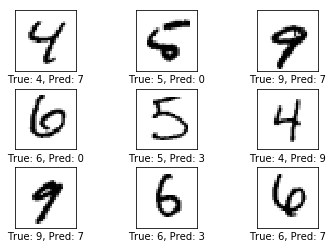

In [41]:
print_test_accuracy(show_example_errors=True)

<b><h2>Performance after 1000 optimization iterations

In [42]:
optimize(num_iterations=900)

Iteration:    101, Accuracy:  59.4%
Iteration:    201, Accuracy:  84.4%
Iteration:    301, Accuracy:  85.9%
Iteration:    401, Accuracy:  89.1%
Iteration:    501, Accuracy:  87.5%
Iteration:    601, Accuracy:  92.2%
Iteration:    701, Accuracy:  95.3%
Iteration:    801, Accuracy:  89.1%
Iteration:    901, Accuracy:  93.8%
Time Taken: 0:04:16


Accuracy on Test Set: 93.3% (9327 / 10000)
Example errors:


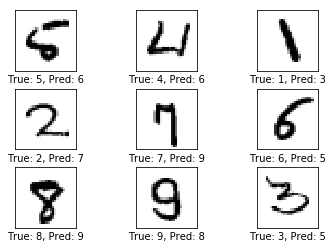

In [43]:
print_test_accuracy(show_example_errors=True)

<b><h2>Performance after 10,000 optimization iterations

In [44]:
optimize(num_iterations=9000)

Iteration:   1001, Accuracy:  95.3%
Iteration:   1101, Accuracy:  87.5%
Iteration:   1201, Accuracy:  85.9%
Iteration:   1301, Accuracy:  98.4%
Iteration:   1401, Accuracy:  95.3%
Iteration:   1501, Accuracy:  95.3%
Iteration:   1601, Accuracy:  90.6%
Iteration:   1701, Accuracy:  93.8%
Iteration:   1801, Accuracy:  95.3%
Iteration:   1901, Accuracy:  92.2%
Iteration:   2001, Accuracy:  96.9%
Iteration:   2101, Accuracy:  96.9%
Iteration:   2201, Accuracy:  96.9%
Iteration:   2301, Accuracy: 100.0%
Iteration:   2401, Accuracy:  98.4%
Iteration:   2501, Accuracy:  98.4%
Iteration:   2601, Accuracy:  90.6%
Iteration:   2701, Accuracy:  98.4%
Iteration:   2801, Accuracy:  95.3%
Iteration:   2901, Accuracy:  96.9%
Iteration:   3001, Accuracy:  95.3%
Iteration:   3101, Accuracy:  98.4%
Iteration:   3201, Accuracy:  96.9%
Iteration:   3301, Accuracy:  92.2%
Iteration:   3401, Accuracy:  95.3%
Iteration:   3501, Accuracy:  98.4%
Iteration:   3601, Accuracy:  96.9%
Iteration:   3701, Accuracy:

Accuracy on Test Set: 98.9% (9891 / 10000)
Example errors:


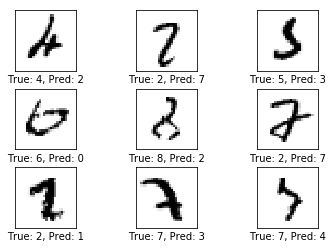

Confusion Matrix:
[[ 975    0    0    0    0    0    0    1    3    1]
 [   0 1128    3    0    0    1    2    1    0    0]
 [   2    1 1020    1    0    0    0    4    4    0]
 [   0    0    2 1002    0    3    0    0    1    2]
 [   0    0    1    0  974    0    1    2    0    4]
 [   2    0    1    4    0  880    1    2    0    2]
 [   3    2    0    0    2    4  947    0    0    0]
 [   0    1    4    1    1    0    0 1017    1    3]
 [   2    0    3    4    2    2    0    2  954    5]
 [   1    4    0    2    3    2    1    2    0  994]]


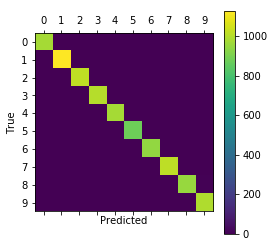

In [45]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

<b><h2>Visualizing Weights and Layers

In [46]:
#Helper Function for Plotting Convolutional Weights
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [47]:
#Helper-function for plotting the output of a convolutional layer
def plot_conv_layer(layer, image):
    feed_dict = {input_images: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

<b><h2>Input Images

In [48]:
#Helper Function to plot a single image
def plot_image(image):
    plt.imshow(image.reshape(shape_of_image), interpolation='nearest', cmap='binary')
    plt.show()

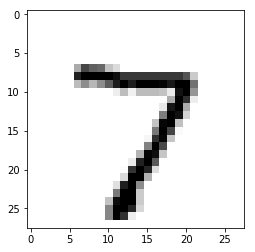

In [49]:
#Plotting Image Example 1
image1 = data.test.images[0]
plot_image(image1)

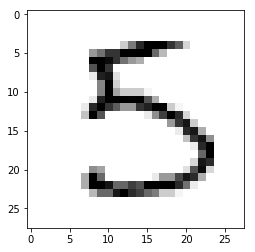

In [50]:
#Plotting Image Example 2
image2 = data.test.images[15]
plot_image(image2)

<b><h2>Plotting weights and layers

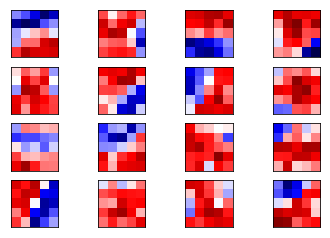

In [51]:
plot_conv_weights(weights=Conv_Weights_1)

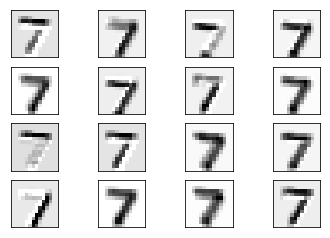

In [52]:
plot_conv_layer(layer=Conv_Layer_1, image=image1)

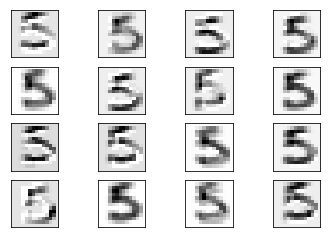

In [53]:
plot_conv_layer(layer=Conv_Layer_1, image=image2)

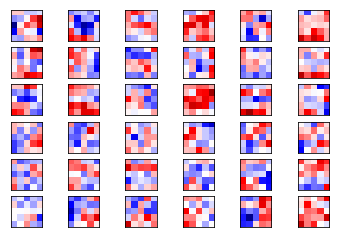

In [54]:
plot_conv_weights(weights=Conv_Weights_2, input_channel=0)

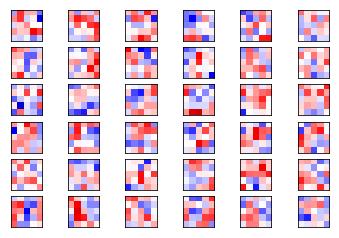

In [55]:
plot_conv_weights(weights=Conv_Weights_2, input_channel=1)

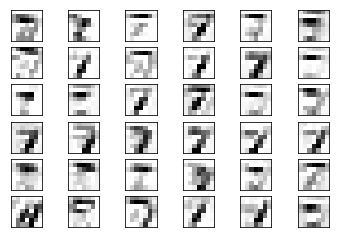

In [56]:
plot_conv_layer(layer=Conv_Layer_2, image=image1)

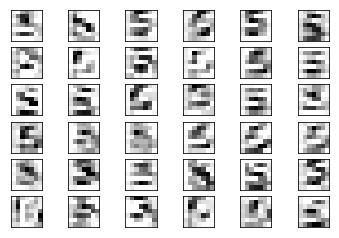

In [57]:
plot_conv_layer(layer=Conv_Layer_2, image=image2)

<b><h2>Closing Tensorflow Session

In [58]:
session.close()

<b><h1><center>!---The End---!